In [2]:
import numpy as np
import cv2
from PIL import Image
import torch
import matplotlib.pyplot as plt

In [5]:

def segment(image_path, input_points):
    # Load when used not on startup
    from transformers import SamModel, SamProcessor

    model = SamModel.from_pretrained("facebook/sam-vit-base")
    processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

    raw_image = Image.open(image_path)
    input_points_nested = [[[[coord[0], coord[1]]] for coord in input_points]]
    inputs = processor(raw_image, input_points=input_points_nested, return_tensors="pt")
    outputs = model(**inputs)

    masks = processor.image_processor.post_process_masks(
        outputs.pred_masks,
        inputs["original_sizes"],
        inputs["reshaped_input_sizes"],
        return_tensors="pt",
    )
    scores = outputs.iou_scores

    return masks, scores

def composite_mask(masks):
    num_masks = masks[0].shape[0]
    final_image = np.zeros(masks[0][0][0].shape)
    instances_list = []

    for i in range(num_masks):
        mask_np = np.array(masks[0][i][2], dtype=np.uint8)

        final_image += mask_np

        seg = mask_to_polygons(mask_np)
        bbox = mask_to_bboxes(mask_np)
        
        instance_dict = {}
        instance_dict['segmentation'] = seg
        instance_dict['bbox'] = bbox

        instances_list.append(instance_dict)

    final_image = np.where(final_image > 1, 1, final_image)

    return final_image, num_masks, instances_list

def mask_to_polygons(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours:
        if len(contour) > 2:
            poly = contour.reshape(-1).tolist()
            polygons.append(poly)
    return polygons[0]

def mask_to_bboxes(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    bboxes = []
    for contour in contours:
        if len(contour) > 2:
            x, y, w, h = cv2.boundingRect(contour)
            bboxes.append([x, y, x + w, y + h])
    return bboxes[0]

In [6]:
input_points = [(284, 443), (271, 389), (268, 340), (268, 340)]
# input_points_nested = [[[[coord[0], coord[1]]] for coord in input_points]]
# points_tensor = torch.tensor(input_points_nested)
# points_tensor.shape
# reshape_tensor = points_tensor.reshape(1, 1, 4, 2)
# reshape_tensor.shape

In [7]:
# print(input_points_nested)
masks, scores = segment("C:/Users/joshua/garnercode/cellCountingModel/notebooks/yolobooks/dataset/inference_dump/C1_PPN1/D_Amp1_PPN1.png", input_points)

In [8]:
final_image, num_masks, instances_list = composite_mask(masks)

In [9]:
indices_above_one = np.argwhere(final_image > 1)
print(indices_above_one)

[]


In [10]:
final_image_pil = Image.fromarray((final_image * 255).astype(np.uint8))
final_image_pil.save('final_image.png')

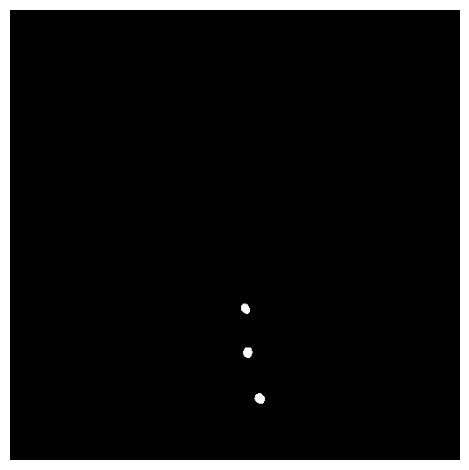

In [14]:
plt.imshow(final_image, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()